In [1]:
import sys
sys.path.append("../../")

from astronn.datasets import deltascuti, bedding, starmodels
from astronn import models

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import shap
from scipy.signal import find_peaks

import matplotlib.pyplot as plt

Using TensorFlow backend.


### The next Period-Luminosity relation is obtained by using the data provided in McNamara (2011):

$\ln \text{L}_\odot = 1.4722 (0.100) \ln \text{P} + 2.6089 (0.096)$

&nbsp;
&nbsp;


### Period (variable $\text{P}$) is isolated to obtained its value given the Luminosity.

$\ln \text{L}_\odot - 2.6089 (0.096) = 1.4722 (0.100) \ln \text{P}$

$\ln \text{P} = \Large\frac{\ln \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}$

$\text{P} = 10\Large^{\Large\frac{\ln \text{L}_\odot - 2.6089 (0.096)}{1.4722 (0.100)}}$

&nbsp;

The fundamental radial mode $\text{P}_0$ is related to the mean density by the pulsation constant $\text{Q} = \text{P} \cdot \Large\sqrt{\frac{\rho}{\rho_\odot}}$ (see Breger, 1990). For $\text{P}_0$ the value of $\text{Q} = [0.03, 0.0492] \text{ (days)}$

Thus, by isolating $\frac{\rho}{\rho_\odot}$ in the above equation and given the value of $\text{P}$, we have a direct estimation of the mean density, as follows:

&nbsp;

$\Large\frac{\rho}{\rho_\odot} = \Big( \frac{Q}{P}\Big)^2$

In [2]:
def get_log_l(P, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P-L relation for McNamara (2011)
    """
    return A * np.log10(P) + B


def get_P(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    P variable isolated from log_L relation
    """
    return np.power(10, (log_L - B) / (A))

def get_rho_from_P(P, Q=0.033):
    """
    """
    return np.power(Q/P, 2)

# Example
P = 2.34
log_l = get_log_l(P=P)
P_equation = get_P(log_L=log_l)
print("P value = %f" % P)
print("log L is equal to %f" % log_l)
print("P from equation %f" % P_equation)
# Assert results
np.testing.assert_almost_equal(P, P_equation)

P value = 2.340000
log L is equal to 3.152460
P from equation 2.340000


## Relate to the error, we use a standard error propagation to calculate it:

$\Delta P = \sqrt{\Big(\frac{\delta \text{P}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \text{P}}{\delta \text{B}}\Delta\text{B}\Big)^2   +    \Big(\frac{\delta \text{P}}{\delta \text{L}}\Delta\text{L}\Big)^2}$ where $A = 1.4722$ with uncertainty $\Delta A = 0.100$ and $B = 2.6089$ with uncertainty $\Delta A = 0.096$

$\Delta P = \sqrt{ \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A^2) * \text{L}_\odot * \Delta A \Big)^2 + \Big( 10^{\frac{\text{L}_\odot - B}{A}}  * (2.30258509 * A) *  \Delta B \Big)^2}$

In [3]:
def p_error(log_L, A=1.4722, e_A=0.1, B=2.6089, e_B=0.096):
    """
    """
    return np.sqrt(
        np.power(
            np.power(10, (log_L - B) / A) * (2.30258509 / np.power(A, 2)) * log_L * e_A,
            2,
        )
        + np.power(np.power(10, (log_L - B) / A) * (2.30258509 / A) * e_B, 2)
    )


l_value = 1.3
print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=1.3), p_error(log_L=1.3))
)

Period for L=1.300000 is equal to 0.129099 +-(0.026337)


### Relation Rodriguez-Martin et.al. 2020

$\frac{\bar{\rho}}{\rho} = 1.6^{+0.5}_{-0.4} \Big( \langle\Delta\nu\rangle / \Delta\nu_\odot \Big)^{2.02^{+0.10}_{-0.10}}$

For the moment, we will use a simetric error in the first term i.e.: $1.6^{+0.5}_{-0.5}$

$\Delta \frac{\bar{\rho}}{\rho} = \sqrt{\Big(\frac{\delta \text{P}}{\delta \text{A}}\Delta\text{A}\Big)^2  +  \Big(\frac{\delta \text{P}}{\delta \text{B}}\Delta\text{B}\Big)^2 }$ where $A = 1.6$ with uncertainty $\Delta A = 0.5$ and $B = 2.02$ with uncertainty $\Delta A = 0.1$

$\Delta \frac{\bar{\rho}}{\rho}  = \sqrt{ ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B * \Delta \text{A} )^2 +  (A * ( {\langle\Delta\nu\rangle / \Delta\nu_\odot} )^B + \ln(x) * \Delta B)^2 }$


In [4]:
def get_rho(delta_nu):
    """
    """
    return 1.6 * np.power(delta_nu, 2.02)


def rho_error(delta_nu, A=1.6, e_A=0.5, B=2.02, e_B=0.1):
    """
    """
    return np.sqrt(
        np.power(np.power(delta_nu, B) * e_A, 2) 
        + np.power(A * np.power(delta_nu, B) * np.log10(delta_nu) * e_B, 2)
    )

delta_nu_value = 1.3
print(
    "Delta_nu == %f is a rho equal to %f +-(%f)"
    % (l_value, get_rho(delta_nu=delta_nu_value), rho_error(delta_nu=delta_nu_value))
)

Delta_nu == 1.300000 is a rho equal to 2.718226 +-(0.850010)


#### Load pre-trained NN model

In [5]:
# Load model
sepconv_mod = tf.keras.models.load_model("/home/roberto/Projects/sepconvnn_tmp_400/")
sepconv_mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d (SeparableC (None, 397, 10)           610       
_________________________________________________________________
batch_normalization (BatchNo (None, 397, 10)           40        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 198, 10)           0         
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 194, 10)           1510      
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 10)           40        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 97, 10)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 47, 10)            1

#### Read an process 11 binaries DS

##### Calculate Luminosity

In [6]:
csv_ds = pd.read_csv("../data/deltascuti/binaries_obs.csv")

# 1 mas = 0.00099999995874704 arcsec
Mv = csv_ds["mv"] + 5 * (np.log10(csv_ds["parallax"] * 0.00099999995874704) + 1)
mbolsun = 4.74
# calculate Luminosity
csv_ds["L"] = (np.power(10, 0.4 * (mbolsun - Mv))) * csv_ds["L.Ltot"]

# Filter and add HD15082 info
csv_ds = csv_ds[["ID", "Dnu_muHz", "L", "Teff"]]
csv_ds.loc[len(csv_ds)] = ["HD15082", 0, 6.14, 0]
csv_ds.head(11)

,ID,Dnu_muHz,L,Teff
0,KIC3858884,29,21.520774,6606
1,KIC4544587,74,6.475306,7750
2,KIC10661783,39,29.304625,7764
3,HD172189,19,29.942319,7750
4,CID100866999,56,NaN,7300
5,CID105906206,20,9.995060,6750
6,HD159561,38,24.642612,8047
7,KIC9851944,26,60.062351,6902
8,KIC8262223,77,1.333914,9128
9,KIC10080943,52,7.085301,7480


In [7]:
for l_value in csv_ds["L"]:
    print(
    "Period for L=%f is equal to %f +-(%f)"
    % (l_value, get_P(log_L=np.log10(l_value)), p_error(log_L=np.log10(l_value)))
    )

Period for L=21.520774 is equal to 0.135907 +-(0.028049)
Period for L=6.475306 is equal to 0.060110 +-(0.010407)
Period for L=29.304625 is equal to 0.167616 +-(0.036273)
Period for L=29.942319 is equal to 0.170085 +-(0.036929)
Period for L=nan is equal to nan +-(nan)
Period for L=9.995060 is equal to 0.080724 +-(0.014847)
Period for L=24.642612 is equal to 0.149005 +-(0.031399)
Period for L=60.062351 is equal to 0.272908 +-(0.065866)
Period for L=1.333914 is equal to 0.020553 +-(0.003098)
Period for L=7.085301 is equal to 0.063900 +-(0.011197)
Period for L=6.140000 is equal to 0.057977 +-(0.009967)


In [8]:
# Load star models dataset
sm = starmodels()
sm_df = sm.load("/home/roberto/Downloads/dataall_parts/*")

dnu_sun = 134.8

# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load(
    "/home/roberto/Downloads/dataall_parts/*", batch_size=150, add_noise=True
)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)

# Save results and predictions
results = {}
for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Save results
    if star[0].numpy()[0].decode("utf-8") not in results:
        results[star[0].numpy()[0].decode("utf-8")] = {
            "inference": sepconv_mod.predict_classes(star[1]),
            "target": target,
        }

    probs = sepconv_mod.predict_proba(star[1])[0]
    peaks, _ = find_peaks(probs, height=0, distance=10)
    peaks_sorted_by_prob = np.sort(probs[peaks])[::-1]

    # save top-k
    results[star[0].numpy()[0].decode("utf-8")]["top-k1"] = np.where(
        probs == peaks_sorted_by_prob[0]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k2"] = np.where(
        probs == peaks_sorted_by_prob[1]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k3"] = np.where(
        probs == peaks_sorted_by_prob[2]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["top-k4"] = np.where(
        probs == peaks_sorted_by_prob[3]
    )[0][0]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk1"] = probs[
        np.where(probs == peaks_sorted_by_prob[1])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk2"] = probs[
        np.where(probs == peaks_sorted_by_prob[2])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk3"] = probs[
        np.where(probs == peaks_sorted_by_prob[3])[0][0]
    ]
    results[star[0].numpy()[0].decode("utf-8")]["prob-topk4"] = probs[
        np.where(probs == peaks_sorted_by_prob[4])[0][0]
    ]

    # Get rho
    results[star[0].numpy()[0].decode("utf-8")]["rho-target"] = get_rho(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k1"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k2"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k3"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["rho-top-k4"] = get_rho(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get errors in rho
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-target"] = rho_error(
        target / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k1"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k1"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k2"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k2"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k3"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k3"] / dnu_sun
    )
    results[star[0].numpy()[0].decode("utf-8")]["e-rho-top-k4"] = rho_error(
        results[star[0].numpy()[0].decode("utf-8")]["top-k4"] / dnu_sun
    )

    # Get P from L
    L = csv_ds[csv_ds.ID.eq(star[0].numpy()[0].decode("utf-8").upper())]["L"].values

    # Check for non L in csv or NaN value
    if len(L) > 0 and not np.isnan(L):
        P = get_P(np.log10(L))
        p_e = p_error(log_L=np.log10(L))

        rho_q_up = get_rho_from_P(P+p_e, Q=0.033)
        rho_q_down = get_rho_from_P(P-p_e, Q=0.042)
        vrrhosun = 1.409
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = rho_q_up[0]
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = rho_q_down[0]
    else:
        print(star[0].numpy()[0].decode("utf-8"))
        print(L)
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-up"] = np.nan
        results[star[0].numpy()[0].decode("utf-8")]["rho-from-P-down"] = np.nan

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
CID100866999
[nan]


In [9]:
df = pd.DataFrame(
    columns=[
        "id",
        "rho-target",
        "e-rho-target",
        "rho-top-k1",
        "e-rho-top-k1",
        "rho-top-k2",
        "e-rho-top-k2",
        "rho-top-k3",
        "e-rho-top-k3",
        "rho-top-k4",
        "e-rho-top-k4",
        "rho-from-P-up",
        "rho-from-P-down"
    ]
)
for i, id in enumerate(results):
    df.loc[i] = [
        id,
        results[id]["rho-target"],
        results[id]["e-rho-target"],
        results[id]["rho-top-k1"],
        results[id]["e-rho-top-k1"],
        results[id]["rho-top-k2"],
        results[id]["e-rho-top-k2"],
        results[id]["rho-top-k3"],
        results[id]["e-rho-top-k3"],
        results[id]["rho-top-k4"],
        results[id]["e-rho-top-k4"],
        results[id]["rho-from-P-up"],
        results[id]["rho-from-P-down"],
    ]
df

,id,rho-target,e-rho-target,rho-top-k1,e-rho-top-k1,rho-top-k2,e-rho-top-k2,rho-top-k3,e-rho-top-k3,rho-top-k4,e-rho-top-k4,rho-from-P-up,rho-from-P-down
0,KIC10080943,0.233600,0.073637,0.071811,0.022947,0.252105,0.079417,0.389778,0.122379,0.014201,0.004666,0.193099,0.635086
1,kic10661783,0.130646,0.041429,0.571855,0.179152,0.123968,0.039335,0.438216,0.137485,0.030565,0.009899,0.026196,0.102256
2,kic4544587,0.476425,0.149399,0.104994,0.033382,0.030565,0.009899,0.502794,0.157621,0.252105,0.079417,0.219004,0.714058
3,HD15082,0.557684,0.174734,0.707483,0.221437,0.502794,0.157621,0.215807,0.068077,0.000734,0.000260,0.235894,0.765308
4,CID105906206,0.033902,0.010961,0.041100,0.013245,0.099022,0.031506,0.224615,0.070830,0.008359,0.002778,0.119230,0.406473
5,KIC9851944,0.057596,0.018463,0.087609,0.027919,0.166694,0.052719,0.041100,0.013245,0.261625,0.082390,0.009489,0.041151
6,KIC8262223,0.516247,0.161815,0.041100,0.013245,0.087609,0.027919,0.159130,0.050351,0.322487,0.101387,1.946743,5.789546
7,HD159561,0.123968,0.039335,0.117466,0.037296,0.041100,0.013245,0.215807,0.068077,0.502794,0.157621,0.033461,0.127537
8,HD172189,0.030565,0.009899,0.044961,0.014468,0.130646,0.041429,0.215807,0.068077,0.012081,0.003983,0.025411,0.099491
9,CID100866999,0.271323,0.085418,0.224615,0.070830,0.037414,0.012076,0.322487,0.101387,0.676085,0.211647,NaN,NaN


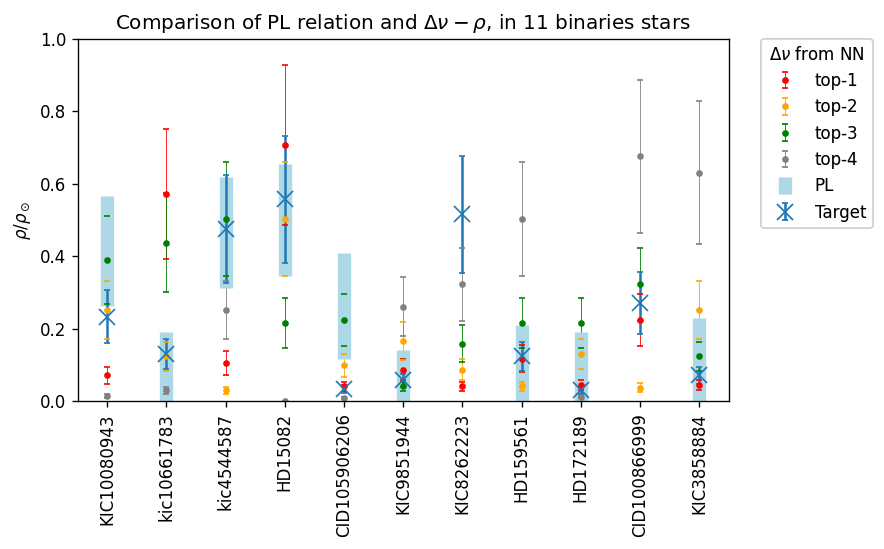

In [10]:
plt.subplots(1, figsize=(7, 4), dpi=120)

p1,p1,p1 = plt.errorbar(
    df["id"],
    df["rho-top-k1"],
    df["e-rho-top-k1"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="red",
    label="top-1",
)
p2,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k2"],
    df["e-rho-top-k2"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="orange",
    label="top-2",
)
p3,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k3"],
    df["e-rho-top-k3"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="green",
    label="top-3",
)
p4,_,_ = plt.errorbar(
    df["id"],
    df["rho-top-k4"],
    df["e-rho-top-k4"],
    elinewidth=0.5,
    markersize=3,
    capsize=2,
    fmt="o",
    color="grey",
    label="top-4",
)
p5,_,_ = plt.errorbar(
    df["id"],
    (df["rho-from-P-up"] + df["rho-from-P-down"]) / 2,
    (df["rho-from-P-up"] / df["rho-from-P-down"]) / 2,
    elinewidth=8,
    fmt="o",
    markersize=0,
    capsize=0,
    label="PL",
    color="lightblue",
)
p6,_,_ = plt.errorbar(
    df["id"],
    df["rho-target"],
    df["e-rho-target"],
    fmt="x",
    markersize=10,
    capsize=2,
    label="Target",
)
plt.xticks(rotation=90)

legend1 = plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
    title=r"$\Delta\nu$ from NN",
)
plt.gca().add_artist(legend1)

plt.ylabel("$\\rho / \\rho_\\odot$")
plt.title("Comparison of PL relation and $\Delta\\nu-\\rho$, in 11 binaries stars")
plt.ylim(0, 1.0)
plt.show()